In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import lal
from pycbc.types.timeseries import TimeSeries
from pycbc import frame
from pycbc.psd import welch
from tqdm import tqdm

### 1. CE detector noise ASD.

In [4]:
path_CE_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"
path_det_CE_noise = "/mnt/d/project_data/psd_3g/data/CE/CE_6h/det_noise_CE_21600s.gwf"
asd_CE = np.loadtxt(path_CE_design_asd, unpack=True, skiprows=1)

start_time = 3600
stride = 512
psd_stride = 16
end_time = start_time + stride
psd_list = []

for i in tqdm(range(int((21600-3600)/stride))):
    det_noise = frame.read_frame(location=path_det_CE_noise, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    delta_t = 1.0/det_noise.sample_rate
    seg_len = int(psd_stride/delta_t)
    seg_stride = int(seg_len/2)
    estimated_psd_det = welch(det_noise.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    psd_list.append(estimated_psd_det.data)
    start_time += stride
    end_time += stride
    if end_time > 21600:
        break

psd_list = np.array(psd_list)
print(psd_list)
print(np.shape(psd_list))

name_keys = {'frequency': np.array(estimated_psd_det.sample_frequencies).T}
for i in range(len(psd_list)):
    name_keys['psd_%s' % i] = psd_list[i]
det_psd_file = pd.DataFrame(name_keys)
det_psd_file.to_csv("./psd_CE_det_512s_16s_5h.csv", index=False, sep=',')

 97%|█████████▋| 34/35 [31:36<00:55, 55.78s/it]


[[3.50788507e-59 7.10236328e-59 7.31515087e-59 ... 3.18769526e-49
  3.70970219e-49 7.31996376e-50]
 [3.04969931e-59 6.10885288e-59 6.13728988e-59 ... 5.43713474e-49
  5.25651128e-49 1.56874468e-49]
 [2.28958860e-59 4.58814928e-59 4.61513136e-59 ... 4.82432070e-49
  6.23781676e-49 1.21962839e-49]
 ...
 [2.29586084e-59 4.60966285e-59 4.66366460e-59 ... 6.23149548e-49
  4.91914315e-49 9.38443482e-50]
 [2.96474376e-59 5.94045010e-59 5.97344499e-59 ... 4.86577970e-49
  4.58063900e-49 2.06193982e-49]
 [1.47639529e-59 2.95911790e-59 3.10012958e-59 ... 5.67957996e-49
  5.78310448e-49 1.68094690e-49]]
(35, 32769)


In [10]:
median_psd = np.median(psd_list, axis=0)
print(median_psd)

max_psd = np.max(psd_list, axis=0)
print(max_psd)

min_psd = np.min(psd_list, axis=0)
print(min_psd)

[2.79679849e-59 5.60628173e-59 5.64447825e-59 ... 5.26567906e-49
 4.88054381e-49 1.44491120e-49]
[4.32432557e-59 8.75145089e-59 9.06100962e-59 ... 7.99971667e-49
 7.42775391e-49 2.66925790e-49]
[1.46112473e-59 2.93186233e-59 2.96080682e-59 ... 2.60697268e-49
 2.96258189e-49 7.31996376e-50]


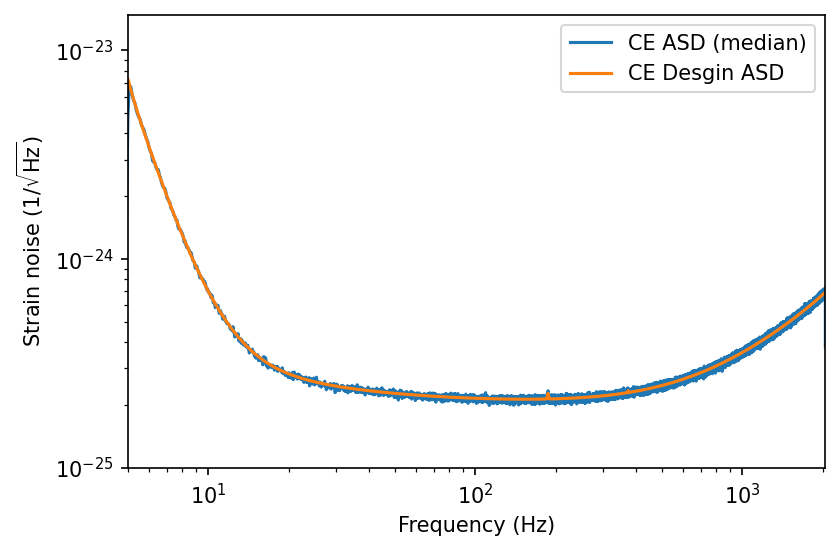

In [14]:
plt.figure(dpi=150)

# plt.loglog(estimated_psd_det.sample_frequencies, np.sqrt(estimated_psd_det), label="CE ASD")
plt.loglog(estimated_psd_det.sample_frequencies, np.sqrt(median_psd), label="CE ASD (median)")

plt.loglog(asd_CE[0], asd_CE[1], label="CE Desgin ASD")
plt.xlim(5, det_noise.sample_rate/2)
plt.ylim(10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="upper right")
plt.show()

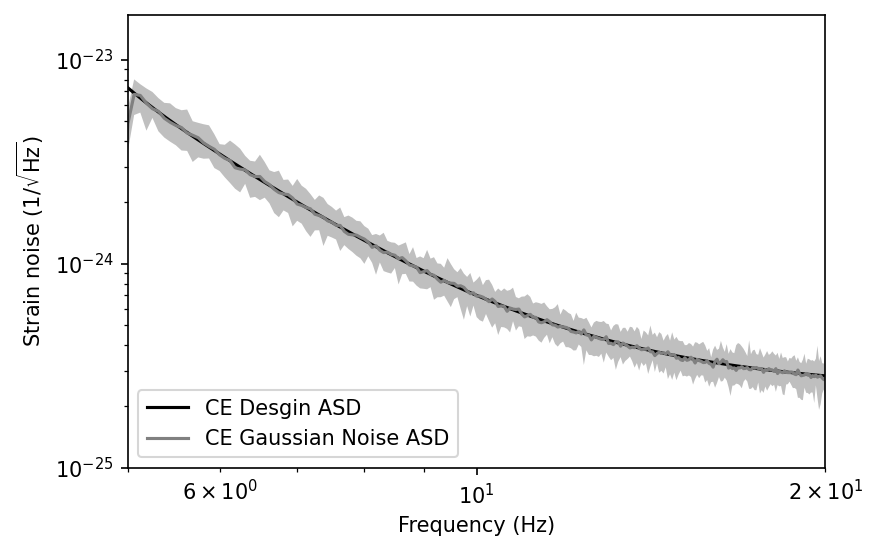

In [26]:
plt.figure(dpi=150)

plt.loglog(asd_CE[0], asd_CE[1], color="black", label="CE Desgin ASD")
# plt.loglog(estimated_psd_det.sample_frequencies, np.sqrt(estimated_psd_det), label="CE ASD")
plt.loglog(estimated_psd_det.sample_frequencies, np.sqrt(median_psd), color="gray", label="CE Gaussian Noise ASD")
plt.fill_between(estimated_psd_det.sample_frequencies, np.sqrt(min_psd), np.sqrt(max_psd), alpha=.5, linewidth=0, color="gray")

plt.xlim(5, 20)
plt.ylim(10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="lower left")
plt.show()

### 2. CE total noise ASD (median R0).

In [3]:
# median local merger rate

path_bbh_CE_median = "/mnt/d/project_data/psd_3g/data/CE/bbh_median_CE_norotation_6h/confusion_noise_CE_1_BBH_21600s.gwf"
path_bns_CE_median = "/mnt/d/project_data/psd_3g/data/CE/bns_median_CE_norotation_6h/confusion_noise_CE_1_BNS_21600s.gwf"
path_nsbh_CE_median = "/mnt/d/project_data/psd_3g/data/CE/nsbh_median_CE_norotation_6h/confusion_noise_CE_1_NSBH_21600s.gwf"
path_det_CE_noise = "/mnt/d/project_data/psd_3g/data/CE/CE_6h/det_noise_CE_21600s.gwf"

start_time = 3600
stride = 512
psd_stride = 16
end_time = start_time + stride
psd_list_bbh_CE_median = []
psd_list_bns_CE_median = []
psd_list_nsbh_CE_median = []
psd_list_total_median = []

for i in tqdm(range(int((21600-3600)/stride))):
    bbh_CE_median = frame.read_frame(location=path_bbh_CE_median, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    bns_CE_median = frame.read_frame(location=path_bns_CE_median, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    nsbh_CE_median = frame.read_frame(location=path_nsbh_CE_median, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    det_noise = frame.read_frame(location=path_det_CE_noise, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    total_noise = bbh_CE_median.data + bns_CE_median.data + nsbh_CE_median.data + det_noise.data
    epoch = lal.LIGOTimeGPS(det_noise.start_time)
    total_noise = TimeSeries(total_noise, delta_t=1.0/det_noise.sample_rate, epoch=epoch)
    delta_t = 1.0/bbh_CE_median.sample_rate
    seg_len = int(psd_stride/delta_t)
    seg_stride = int(seg_len/2)
    estimated_psd_bbh_CE_median = welch(bbh_CE_median.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_bns_CE_median = welch(bns_CE_median.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_nsbh_CE_median = welch(nsbh_CE_median.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_total_median = welch(total_noise, seg_len=seg_len, seg_stride=seg_stride)
    psd_list_bbh_CE_median.append(estimated_psd_bbh_CE_median.data)
    psd_list_bns_CE_median.append(estimated_psd_bns_CE_median.data)
    psd_list_nsbh_CE_median.append(estimated_psd_nsbh_CE_median.data)
    psd_list_total_median.append(estimated_psd_total_median.data)
    start_time += stride
    end_time += stride
    if end_time > 21600:
        break

psd_list_bbh_CE_median = np.array(psd_list_bbh_CE_median)
psd_list_bns_CE_median = np.array(psd_list_bns_CE_median)
psd_list_nsbh_CE_median = np.array(psd_list_nsbh_CE_median)
psd_list_total_median = np.array(psd_list_total_median)

# save bbh case
print(psd_list_bbh_CE_median)
print(np.shape(psd_list_bbh_CE_median))

name_keys = {'frequency': np.array(estimated_psd_bbh_CE_median.sample_frequencies).T}
for i in range(len(psd_list_bbh_CE_median)):
    name_keys['psd_%s' % i] = psd_list_bbh_CE_median[i]
bbh_CE_median_psd_file = pd.DataFrame(name_keys)
bbh_CE_median_psd_file.to_csv("./psd_bbh_CE_median_512s_16s_5h.csv", index=False, sep=',')

# save bns case
print(psd_list_bns_CE_median)
print(np.shape(psd_list_bns_CE_median))

name_keys = {'frequency': np.array(estimated_psd_bns_CE_median.sample_frequencies).T}
for i in range(len(psd_list_bns_CE_median)):
    name_keys['psd_%s' % i] = psd_list_bns_CE_median[i]
bns_CE_median_psd_file = pd.DataFrame(name_keys)
bns_CE_median_psd_file.to_csv("./psd_bns_CE_median_512s_16s_5h.csv", index=False, sep=',')

# save nsbh case
print(psd_list_nsbh_CE_median)
print(np.shape(psd_list_nsbh_CE_median))

name_keys = {'frequency': np.array(estimated_psd_nsbh_CE_median.sample_frequencies).T}
for i in range(len(psd_list_nsbh_CE_median)):
    name_keys['psd_%s' % i] = psd_list_nsbh_CE_median[i]
nsbh_CE_median_psd_file = pd.DataFrame(name_keys)
nsbh_CE_median_psd_file.to_csv("./psd_nsbh_CE_median_512s_16s_5h.csv", index=False, sep=',')

# save total case
print(psd_list_total_median)
print(np.shape(psd_list_total_median))

name_keys = {'frequency': np.array(estimated_psd_total_median.sample_frequencies).T}
for i in range(len(psd_list_total_median)):
    name_keys['psd_%s' % i] = psd_list_total_median[i]
total_CE_median_psd_file = pd.DataFrame(name_keys)
total_CE_median_psd_file.to_csv("./psd_total_CE_median_512s_16s_5h.csv", index=False, sep=',')

 97%|█████████▋| 34/35 [1:46:25<03:07, 187.82s/it]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(35, 32769)
[[7.88585661e-62 1.58527656e-61 1.64051341e-61 ... 1.67862949e-60
  1.31272072e-57 1.91150314e-57]
 [9.05036505e-62 2.28573434e-61 2.04950030e-61 ... 6.42368037e-59
  2.01326145e-57 2.78153795e-57]
 [9.02607580e-62 2.37883199e-61 2.20991168e-61 ... 2.20814266e-58
  5.42665823e-57 4.52134111e-57]
 ...
 [2.59617795e-62 4.35296484e-62 4.55405511e-62 ... 4.61264795e-61
  5.25993831e-58 9.58691752e-58]
 [2.21516206e-62 4.45647056e-62 4.45997070e-62 ... 1.84099307e-61
  2.52221495e-58 5.04824166e-58]
 [7.96016982e-63 1.17621668e-62 1.30984511e-62 ... 2.20528612e-62
  4.00015757e-59 7.24871995e-59]]
(35, 32769)
[[5.80187410e-61 1.19773225e-60 1.52204573e-60 ... 9.55552548e-75
  8.52145632e-75 3.79067955e-75]
 [2.54892856e-60 5.38666413e-60 7.03119687e-60 ... 1.78142797e-64
  1.78142078e-64 8.75078983e-65]
 [1.23728460e-60 2.478

In [4]:
median_psd_total_median = np.median(psd_list_total_median, axis=0)
print(median_psd_total_median)

max_psd_total_median = np.max(psd_list_total_median, axis=0)
print(max_psd_total_median)

min_psd_total_median = np.min(psd_list_total_median, axis=0)
print(min_psd_total_median)

[1.00620818e-58 2.11640437e-58 2.16589355e-58 ... 5.26448740e-49
 4.88056196e-49 1.44494832e-49]
[9.25296786e-58 3.65635519e-57 5.36165075e-57 ... 7.99945719e-49
 7.42611963e-49 2.66996888e-49]
[3.17568689e-59 6.36640989e-59 6.88606617e-59 ... 2.60369088e-49
 2.96269820e-49 7.31835278e-50]


In [3]:
# load det
psd_CE_det = pd.read_csv('psd_CE_det_512s_16s_5h.csv')
psd_CE_det = np.array(psd_CE_det).T
# print(psd_CE_det[1:])
# print(np.shape(psd_CE_det[1:]))

mean_psd_CE_det = np.mean(psd_CE_det[1:], axis=0)
print(mean_psd_CE_det)

onesigma_right_psd_CE_det = np.percentile(a=psd_CE_det[1:], q=84.15, axis=0)
print(onesigma_right_psd_CE_det)

onesigma_left_psd_CE_det = np.percentile(a=psd_CE_det[1:], q=15.85, axis=0)
print(onesigma_left_psd_CE_det)

# load bbh
psd_CE_bbh_median = pd.read_csv('psd_bbh_CE_median_512s_16s_5h.csv')
psd_CE_bbh_median = np.array(psd_CE_bbh_median).T

mean_psd_CE_bbh_median = np.mean(psd_CE_bbh_median[1:], axis=0)
onesigma_right_psd_CE_bbh_median = np.percentile(a=psd_CE_bbh_median[1:], q=84.15, axis=0)
onesigma_left_psd_CE_bbh_median = np.percentile(a=psd_CE_bbh_median[1:], q=15.85, axis=0)

# load bns
psd_CE_bns_median = pd.read_csv('psd_bns_CE_median_512s_16s_5h.csv')
psd_CE_bns_median = np.array(psd_CE_bns_median).T

mean_psd_CE_bns_median = np.mean(psd_CE_bns_median[1:], axis=0)
onesigma_right_psd_CE_bns_median = np.percentile(a=psd_CE_bns_median[1:], q=84.15, axis=0)
onesigma_left_psd_CE_bns_median = np.percentile(a=psd_CE_bns_median[1:], q=15.85, axis=0)

# load nsbh
psd_CE_nsbh_median = pd.read_csv('psd_nsbh_CE_median_512s_16s_5h.csv')
psd_CE_nsbh_median = np.array(psd_CE_nsbh_median).T

mean_psd_CE_nsbh_median = np.mean(psd_CE_nsbh_median[1:], axis=0)
onesigma_right_psd_CE_nsbh_median = np.percentile(a=psd_CE_nsbh_median[1:], q=84.15, axis=0)
onesigma_left_psd_CE_nsbh_median = np.percentile(a=psd_CE_nsbh_median[1:], q=15.85, axis=0)

# load total
psd_CE_total_median = pd.read_csv('psd_total_CE_median_512s_16s_5h.csv')
psd_CE_total_median = np.array(psd_CE_total_median).T

mean_psd_CE_total_median = np.mean(psd_CE_total_median[1:], axis=0)
onesigma_right_psd_CE_total_median = np.percentile(a=psd_CE_total_median[1:], q=84.15, axis=0)
onesigma_left_psd_CE_total_median = np.percentile(a=psd_CE_total_median[1:], q=15.85, axis=0)

[2.72191342e-59 5.46904303e-59 5.54264975e-59 ... 5.10786128e-49
 4.95913449e-49 1.47837665e-49]
[3.52995846e-59 7.08919549e-59 7.18096706e-59 ... 5.96428834e-49
 5.84080224e-49 1.80970316e-49]
[1.84633494e-59 3.72284503e-59 3.81368530e-59 ... 4.24800543e-49
 3.99924381e-49 1.04484892e-49]


In [4]:
print(psd_CE_total_median[0])

[0.0000000e+00 6.2500000e-02 1.2500000e-01 ... 2.0478750e+03 2.0479375e+03
 2.0480000e+03]


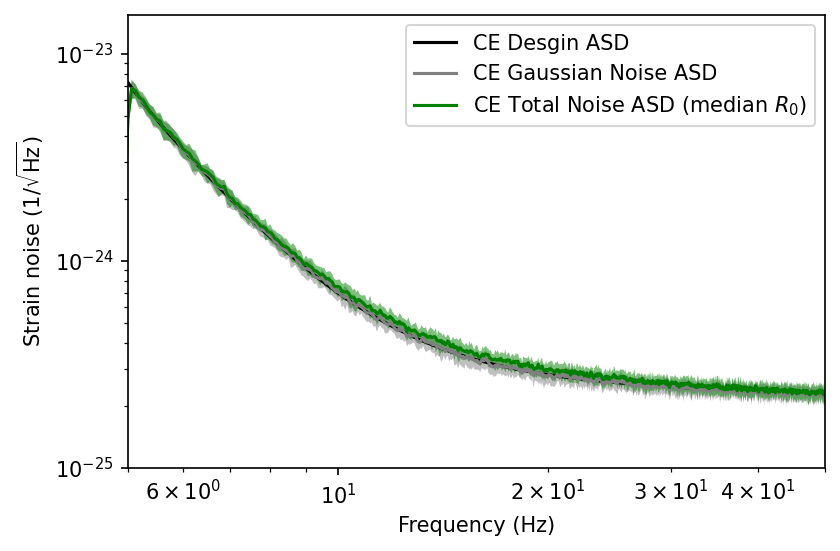

In [5]:
path_CE_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"
asd_CE = np.loadtxt(path_CE_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_CE[0], asd_CE[1], color="black", label="CE Desgin ASD")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_det), color="gray", label="CE Gaussian Noise ASD")
plt.fill_between(psd_CE_det[0], np.sqrt(onesigma_left_psd_CE_det), np.sqrt(onesigma_right_psd_CE_det), alpha=.5, linewidth=0, color="gray")
plt.loglog(psd_CE_total_median[0], np.sqrt(mean_psd_CE_total_median), color="green", label=r"CE Total Noise ASD (median $R_{0}$)")
plt.fill_between(psd_CE_total_median[0], np.sqrt(onesigma_left_psd_CE_total_median), np.sqrt(onesigma_right_psd_CE_total_median), alpha=.5, linewidth=0, color="green")

plt.xlim(5, 50)
plt.ylim(1*10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="upper right")
plt.show()

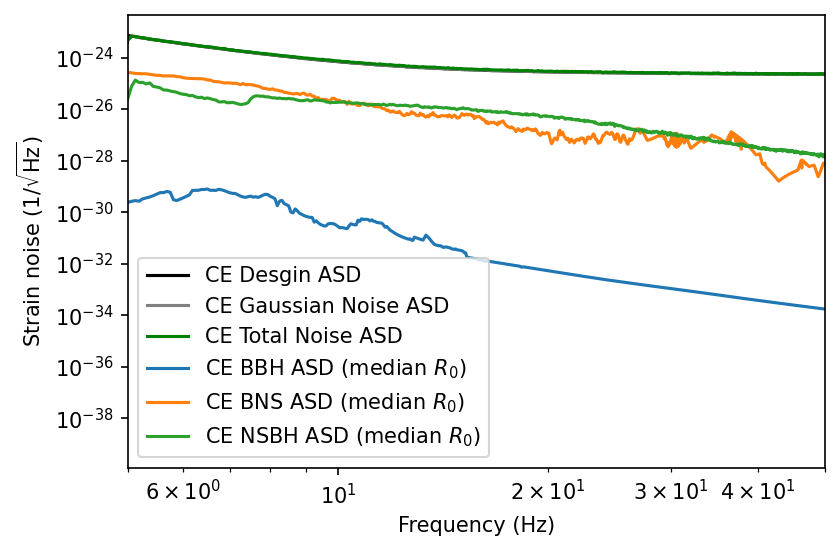

In [6]:
path_CE_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"
asd_CE = np.loadtxt(path_CE_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_CE[0], asd_CE[1], color="black", label="CE Desgin ASD")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_det), color="gray", label="CE Gaussian Noise ASD")
# plt.fill_between(psd_CE_det[0], np.sqrt(min_psd_CE_det), np.sqrt(max_psd_CE_det), alpha=.5, linewidth=0, color="gray")
plt.loglog(psd_CE_total_median[0], np.sqrt(mean_psd_CE_total_median), color="green", label="CE Total Noise ASD")
# plt.fill_between(estimated_psd_total_median.sample_frequencies, np.sqrt(min_psd_total_median), np.sqrt(max_psd_total_median), alpha=.5, linewidth=0, color="green")

plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_bbh_median), label=r"CE BBH ASD (median $R_{0}$)")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_bns_median), label=r"CE BNS ASD (median $R_{0}$)")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_nsbh_median), label=r"CE NSBH ASD (median $R_{0}$)")


plt.xlim(5, 50)
# plt.ylim(1*10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="lower left")
plt.show()

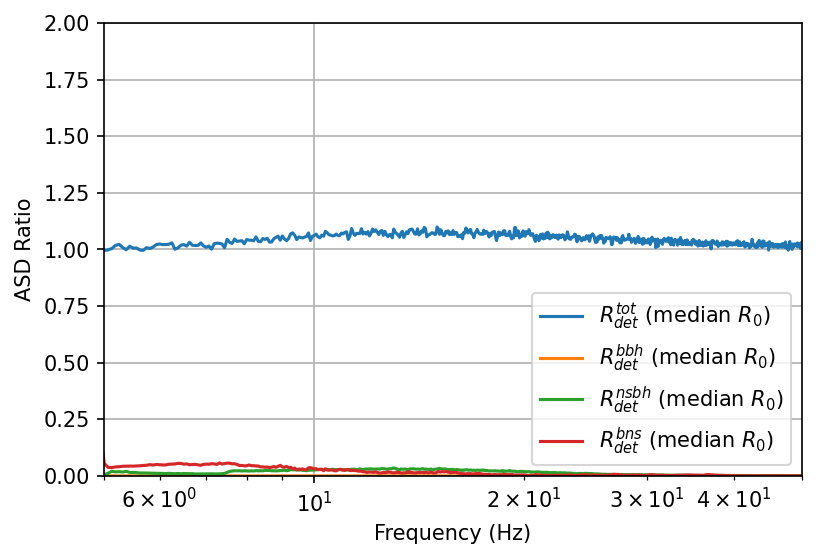

In [7]:
ratio_tot_guassian = np.sqrt(mean_psd_CE_total_median) / np.sqrt(mean_psd_CE_det)
ratio_bbh_guassian = np.sqrt(mean_psd_CE_bbh_median) / np.sqrt(mean_psd_CE_det)
ratio_bns_guassian = np.sqrt(mean_psd_CE_bns_median) / np.sqrt(mean_psd_CE_det)
ratio_nsbh_guassian = np.sqrt(mean_psd_CE_nsbh_median) / np.sqrt(mean_psd_CE_det)

plt.figure(dpi=150)
plt.semilogx(psd_CE_det[0], ratio_tot_guassian, label=r"$R_{det}^{tot}$ (median $R_{0}$)")
plt.semilogx(psd_CE_det[0], ratio_bbh_guassian, label=r"$R_{det}^{bbh}$ (median $R_{0}$)")
plt.semilogx(psd_CE_det[0], ratio_nsbh_guassian, label=r"$R_{det}^{nsbh}$ (median $R_{0}$)")
plt.semilogx(psd_CE_det[0], ratio_bns_guassian, label=r"$R_{det}^{bns}$ (median $R_{0}$)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("ASD Ratio")
plt.xlim(5, 50)
plt.ylim(0, 2)
plt.legend(loc='lower right')
plt.grid()
plt.show()


### 3. CE total noise ASD (upper R0).

In [56]:
# upper local merger rate

path_bbh_CE_upper = "/mnt/d/project_data/psd_3g/data/CE/bbh_upper_CE_norotation_6h/confusion_noise_CE_1_BBH_21600s.gwf"
path_bns_CE_upper = "/mnt/d/project_data/psd_3g/data/CE/bns_upper_CE_norotation_6h/confusion_noise_CE_1_BNS_21600s.gwf"
path_nsbh_CE_upper = "/mnt/d/project_data/psd_3g/data/CE/nsbh_upper_CE_norotation_6h/confusion_noise_CE_1_NSBH_21600s.gwf"
path_det_CE_noise = "/mnt/d/project_data/psd_3g/data/CE/CE_6h/det_noise_CE_21600s.gwf"

start_time = 3600
stride = 512
psd_stride = 16
end_time = start_time + stride
psd_list_bbh_CE_upper = []
psd_list_bns_CE_upper = []
psd_list_nsbh_CE_upper = []
psd_list_total_upper = []

for i in tqdm(range(int((21600-3600)/stride))):
    bbh_CE_upper = frame.read_frame(location=path_bbh_CE_upper, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    bns_CE_upper = frame.read_frame(location=path_bns_CE_upper, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    nsbh_CE_upper = frame.read_frame(location=path_nsbh_CE_upper, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    det_noise = frame.read_frame(location=path_det_CE_noise, channels='H1:LDAS-STRAIN', start_time=start_time, end_time=end_time)
    total_noise = bbh_CE_upper.data + bns_CE_upper.data + nsbh_CE_upper.data + det_noise.data
    epoch = lal.LIGOTimeGPS(det_noise.start_time)
    total_noise = TimeSeries(total_noise, delta_t=1.0/det_noise.sample_rate, epoch=epoch)
    delta_t = 1.0/bbh_CE_upper.sample_rate
    seg_len = int(psd_stride/delta_t)
    seg_stride = int(seg_len/2)
    estimated_psd_bbh_CE_upper = welch(bbh_CE_upper.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_bns_CE_upper = welch(bns_CE_upper.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_nsbh_CE_upper = welch(nsbh_CE_upper.time_slice(start_time, end_time), seg_len=seg_len, seg_stride=seg_stride)
    estimated_psd_total_upper = welch(total_noise, seg_len=seg_len, seg_stride=seg_stride)
    psd_list_bbh_CE_upper.append(estimated_psd_bbh_CE_upper.data)
    psd_list_bns_CE_upper.append(estimated_psd_bns_CE_upper.data)
    psd_list_nsbh_CE_upper.append(estimated_psd_nsbh_CE_upper.data)
    psd_list_total_upper.append(estimated_psd_total_upper.data)
    start_time += stride
    end_time += stride
    if end_time > 21600:
        break

psd_list_bbh_CE_upper = np.array(psd_list_bbh_CE_upper)
psd_list_bns_CE_upper = np.array(psd_list_bns_CE_upper)
psd_list_nsbh_CE_upper = np.array(psd_list_nsbh_CE_upper)
psd_list_total_upper = np.array(psd_list_total_upper)

# save bbh case
print(psd_list_bbh_CE_upper)
print(np.shape(psd_list_bbh_CE_upper))

name_keys = {'frequency': np.array(estimated_psd_bbh_CE_upper.sample_frequencies).T}
for i in range(len(psd_list_bbh_CE_upper)):
    name_keys['psd_%s' % i] = psd_list_bbh_CE_upper[i]
bbh_CE_upper_psd_file = pd.DataFrame(name_keys)
bbh_CE_upper_psd_file.to_csv("./psd_bbh_CE_upper_512s_16s_5h.csv", index=False, sep=',')

# save bns case
print(psd_list_bns_CE_upper)
print(np.shape(psd_list_bns_CE_upper))

name_keys = {'frequency': np.array(estimated_psd_bns_CE_upper.sample_frequencies).T}
for i in range(len(psd_list_bns_CE_upper)):
    name_keys['psd_%s' % i] = psd_list_bns_CE_upper[i]
bns_CE_upper_psd_file = pd.DataFrame(name_keys)
bns_CE_upper_psd_file.to_csv("./psd_bns_CE_upper_512s_16s_5h.csv", index=False, sep=',')

# save nsbh case
print(psd_list_nsbh_CE_upper)
print(np.shape(psd_list_nsbh_CE_upper))

name_keys = {'frequency': np.array(estimated_psd_nsbh_CE_upper.sample_frequencies).T}
for i in range(len(psd_list_nsbh_CE_upper)):
    name_keys['psd_%s' % i] = psd_list_nsbh_CE_upper[i]
nsbh_CE_upper_psd_file = pd.DataFrame(name_keys)
nsbh_CE_upper_psd_file.to_csv("./psd_nsbh_CE_upper_512s_16s_5h.csv", index=False, sep=',')

# save total case
print(psd_list_total_upper)
print(np.shape(psd_list_total_upper))

name_keys = {'frequency': np.array(estimated_psd_total_upper.sample_frequencies).T}
for i in range(len(psd_list_total_upper)):
    name_keys['psd_%s' % i] = psd_list_total_upper[i]
total_CE_upper_psd_file = pd.DataFrame(name_keys)
total_CE_upper_psd_file.to_csv("./psd_total_CE_upper_512s_16s_5h.csv", index=False, sep=',')

 97%|█████████▋| 34/35 [1:50:03<03:14, 194.23s/it]


[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.57325689e-63 2.07087832e-62 2.54085739e-62 ... 3.70083191e-77
  4.85295929e-77 8.79593784e-78]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.30704591e-61 8.64357382e-61 9.44439088e-61 ... 4.75672392e-76
  4.68406607e-76 2.31388101e-76]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(35, 32769)
[[1.04611549e-60 1.76419119e-60 1.85193143e-60 ... 1.51198102e-55
  1.63656855e-55 1.19911880e-55]
 [7.14891506e-61 1.44555923e-60 1.08836636e-60 ... 1.63524748e-55
  3.38440011e-55 2.14791184e-55]
 [4.73317509e-61 7.74226603e-61 9.48260818e-61 ... 1.99690019e-55
  2.34691259e-55 1.13962971e-55]
 ...
 [4.95193985e-61 1.05802148e-60 9.61477021e-61 ... 5.22718426e-56
  6.36823146e-56 4.3

In [8]:
# load det
psd_CE_det = pd.read_csv('psd_CE_det_512s_16s_5h.csv')
psd_CE_det = np.array(psd_CE_det).T
# print(psd_CE_det[1:])
# print(np.shape(psd_CE_det[1:]))

mean_psd_CE_det = np.mean(psd_CE_det[1:], axis=0)
print(mean_psd_CE_det)

onesigma_right_psd_CE_det = np.percentile(a=psd_CE_det[1:], q=84.15, axis=0)
print(onesigma_right_psd_CE_det)

onesigma_left_psd_CE_det = np.percentile(a=psd_CE_det[1:], q=15.85, axis=0)
print(onesigma_left_psd_CE_det)

# load bbh
psd_CE_bbh_upper = pd.read_csv('psd_bbh_CE_upper_512s_16s_5h.csv')
psd_CE_bbh_upper = np.array(psd_CE_bbh_upper).T

mean_psd_CE_bbh_upper = np.mean(psd_CE_bbh_upper[1:], axis=0)
onesigma_right_psd_CE_bbh_upper = np.percentile(a=psd_CE_bbh_upper[1:], q=84.15, axis=0)
onesigma_left_psd_CE_bbh_upper = np.percentile(a=psd_CE_bbh_upper[1:], q=15.85, axis=0)

# load bns
psd_CE_bns_upper = pd.read_csv('psd_bns_CE_upper_512s_16s_5h.csv')
psd_CE_bns_upper = np.array(psd_CE_bns_upper).T

mean_psd_CE_bns_upper = np.mean(psd_CE_bns_upper[1:], axis=0)
onesigma_right_psd_CE_bns_upper = np.percentile(a=psd_CE_bns_upper[1:], q=84.15, axis=0)
onesigma_left_psd_CE_bns_upper = np.percentile(a=psd_CE_bns_upper[1:], q=15.85, axis=0)

# load nsbh
psd_CE_nsbh_upper = pd.read_csv('psd_nsbh_CE_upper_512s_16s_5h.csv')
psd_CE_nsbh_upper = np.array(psd_CE_nsbh_upper).T

mean_psd_CE_nsbh_upper = np.mean(psd_CE_nsbh_upper[1:], axis=0)
onesigma_right_psd_CE_nsbh_upper = np.percentile(a=psd_CE_nsbh_upper[1:], q=84.15, axis=0)
onesigma_left_psd_CE_nsbh_upper = np.percentile(a=psd_CE_nsbh_upper[1:], q=15.85, axis=0)

# load total
psd_CE_total_upper = pd.read_csv('psd_total_CE_upper_512s_16s_5h.csv')
psd_CE_total_upper = np.array(psd_CE_total_upper).T

mean_psd_CE_total_upper = np.mean(psd_CE_total_upper[1:], axis=0)
onesigma_right_psd_CE_total_upper = np.percentile(a=psd_CE_total_upper[1:], q=84.15, axis=0)
onesigma_left_psd_CE_total_upper = np.percentile(a=psd_CE_total_upper[1:], q=15.85, axis=0)

[2.72191342e-59 5.46904303e-59 5.54264975e-59 ... 5.10786128e-49
 4.95913449e-49 1.47837665e-49]
[3.52995846e-59 7.08919549e-59 7.18096706e-59 ... 5.96428834e-49
 5.84080224e-49 1.80970316e-49]
[1.84633494e-59 3.72284503e-59 3.81368530e-59 ... 4.24800543e-49
 3.99924381e-49 1.04484892e-49]


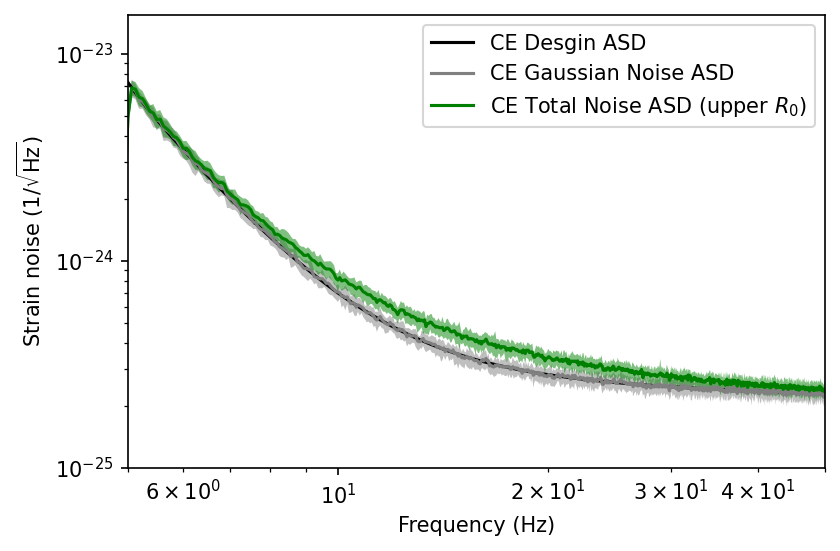

In [9]:
path_CE_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"
asd_CE = np.loadtxt(path_CE_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_CE[0], asd_CE[1], color="black", label="CE Desgin ASD")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_det), color="gray", label="CE Gaussian Noise ASD")
plt.fill_between(psd_CE_det[0], np.sqrt(onesigma_left_psd_CE_det), np.sqrt(onesigma_right_psd_CE_det), alpha=.5, linewidth=0, color="gray")
plt.loglog(psd_CE_total_upper[0], np.sqrt(mean_psd_CE_total_upper), color="green", label=r"CE Total Noise ASD (upper $R_{0}$)")
plt.fill_between(psd_CE_total_upper[0], np.sqrt(onesigma_left_psd_CE_total_upper), np.sqrt(onesigma_right_psd_CE_total_upper), alpha=.5, linewidth=0, color="green")

plt.xlim(5, 50)
plt.ylim(1*10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="upper right")
plt.show()

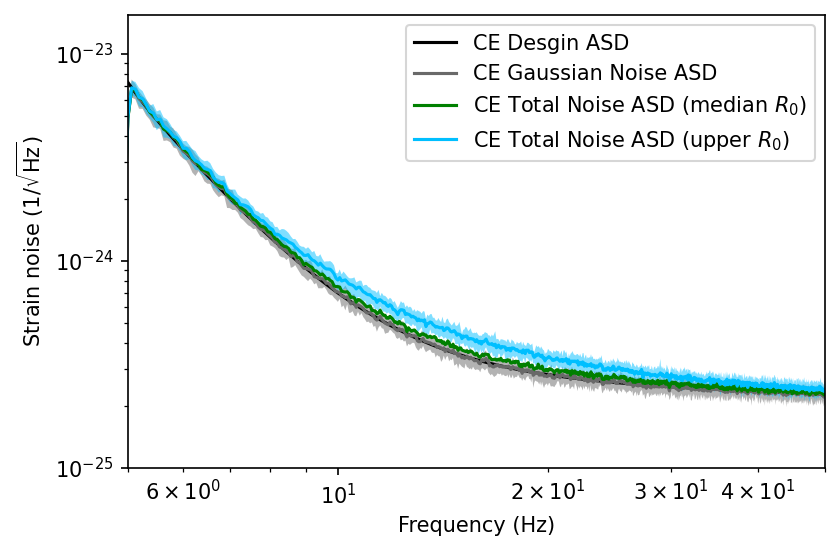

In [9]:
path_CE_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"
asd_CE = np.loadtxt(path_CE_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_CE[0], asd_CE[1], color="black", label="CE Desgin ASD")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_det), color="dimgray", label="CE Gaussian Noise ASD")
plt.fill_between(psd_CE_det[0], np.sqrt(onesigma_left_psd_CE_det), np.sqrt(onesigma_right_psd_CE_det), alpha=.5, linewidth=0, color="dimgray")
plt.loglog(psd_CE_total_median[0], np.sqrt(mean_psd_CE_total_median), color="green", label=r"CE Total Noise ASD (median $R_{0}$)")
plt.loglog(psd_CE_total_upper[0], np.sqrt(mean_psd_CE_total_upper), color="deepskyblue", label=r"CE Total Noise ASD (upper $R_{0}$)")
plt.fill_between(psd_CE_total_upper[0], np.sqrt(onesigma_left_psd_CE_total_upper), np.sqrt(onesigma_right_psd_CE_total_upper), alpha=.5, linewidth=0, color="deepskyblue")

plt.xlim(5, 50)
plt.ylim(1*10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="upper right")
plt.savefig('asd_CE_bias.pdf', dpi=500)
plt.show()

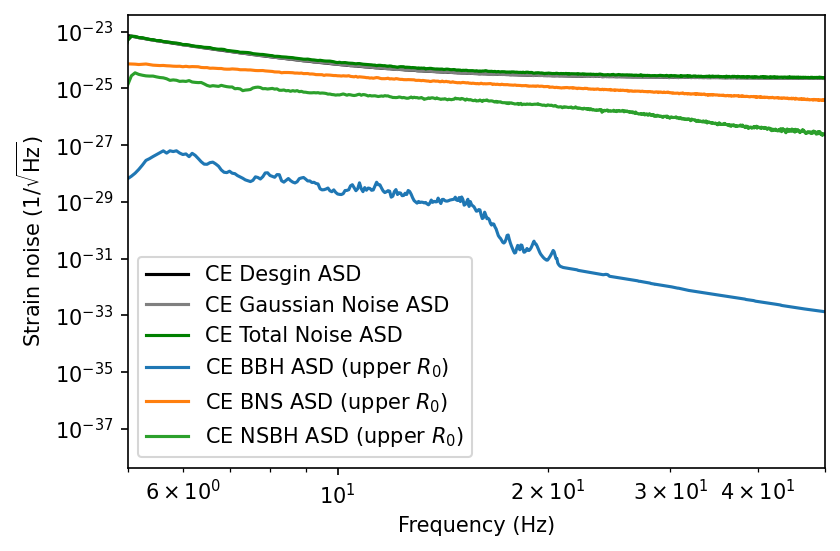

In [10]:
path_CE_design_asd = "/mnt/d/on-source_psd_correction/detector_network/ASD/CE_asd.txt"
asd_CE = np.loadtxt(path_CE_design_asd, unpack=True, skiprows=1)

plt.figure(dpi=150)

plt.loglog(asd_CE[0], asd_CE[1], color="black", label="CE Desgin ASD")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_det), color="gray", label="CE Gaussian Noise ASD")
plt.loglog(psd_CE_total_upper[0], np.sqrt(mean_psd_CE_total_upper), color="green", label="CE Total Noise ASD")

plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_bbh_upper), label=r"CE BBH ASD (upper $R_{0}$)")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_bns_upper), label=r"CE BNS ASD (upper $R_{0}$)")
plt.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_nsbh_upper), label=r"CE NSBH ASD (upper $R_{0}$)")

plt.xlim(5, 50)
# plt.ylim(1*10**(-25), )
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
plt.legend(loc="lower left")
plt.show()

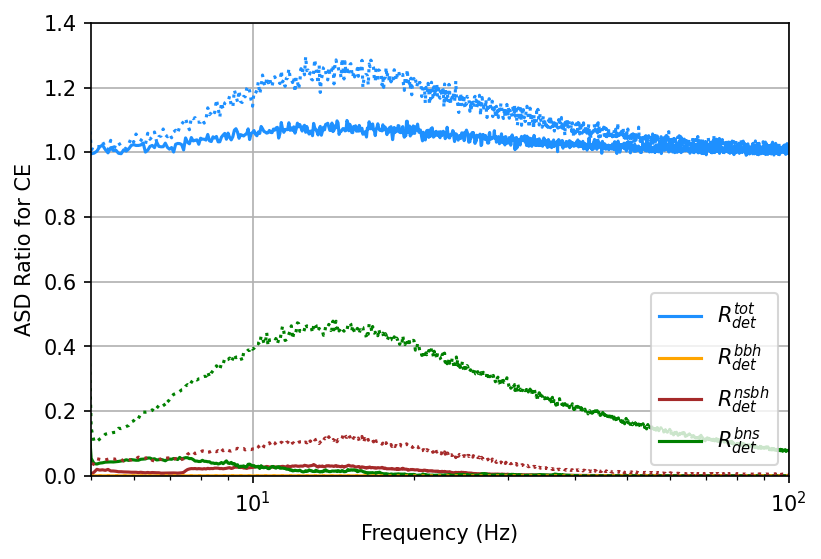

In [10]:
ratio_tot_guassian_median = np.sqrt(mean_psd_CE_total_median) / np.sqrt(mean_psd_CE_det)
ratio_bbh_guassian_median = np.sqrt(mean_psd_CE_bbh_median) / np.sqrt(mean_psd_CE_det)
ratio_bns_guassian_median = np.sqrt(mean_psd_CE_bns_median) / np.sqrt(mean_psd_CE_det)
ratio_nsbh_guassian_median = np.sqrt(mean_psd_CE_nsbh_median) / np.sqrt(mean_psd_CE_det)

ratio_tot_guassian_upper = np.sqrt(mean_psd_CE_total_upper) / np.sqrt(mean_psd_CE_det)
ratio_bbh_guassian_upper = np.sqrt(mean_psd_CE_bbh_upper) / np.sqrt(mean_psd_CE_det)
ratio_bns_guassian_upper = np.sqrt(mean_psd_CE_bns_upper) / np.sqrt(mean_psd_CE_det)
ratio_nsbh_guassian_upper = np.sqrt(mean_psd_CE_nsbh_upper) / np.sqrt(mean_psd_CE_det)

plt.figure(dpi=150)
plt.semilogx(psd_CE_det[0], ratio_tot_guassian_median, color='dodgerblue', label=r"$R_{det}^{tot}$")
plt.semilogx(psd_CE_det[0], ratio_bbh_guassian_median, color='orange', label=r"$R_{det}^{bbh}$")
plt.semilogx(psd_CE_det[0], ratio_nsbh_guassian_median, color='brown', label=r"$R_{det}^{nsbh}$")
plt.semilogx(psd_CE_det[0], ratio_bns_guassian_median, color='green', label=r"$R_{det}^{bns}$")

plt.semilogx(psd_CE_det[0], ratio_tot_guassian_upper, color='dodgerblue', linestyle='dotted')
plt.semilogx(psd_CE_det[0], ratio_bbh_guassian_upper, color='orange', linestyle='dotted')
plt.semilogx(psd_CE_det[0], ratio_nsbh_guassian_upper, color='brown', linestyle='dotted')
plt.semilogx(psd_CE_det[0], ratio_bns_guassian_upper, color='green', linestyle='dotted')

plt.xlabel("Frequency (Hz)")
plt.ylabel("ASD Ratio for CE")
plt.xlim(5, 100)
plt.ylim(0, 1.4)
plt.legend(loc='lower right')
plt.grid()
plt.savefig('asd_ratio_CE.pdf', dpi=500)
plt.show()


In [14]:
print(ratio_tot_guassian_upper[:100])

[ 37.95606684  42.30458743  45.18549917  43.29283362  42.33866209
  45.31894864  47.0907152   42.17831646  46.26283781  43.96751943
  43.97326642  39.77449389  43.46954888  41.10371776  38.20080877
  38.10739685  39.04297276  36.41803128  32.92232246  33.45303919
  32.75862361  31.74797097  30.74357995  32.02126251  30.45330721
  25.92438398  24.6816843   25.61910407  25.99020412  23.34607723
  23.12234888  22.0610655   20.37975065  19.76083929  18.29117509
  19.22414343  20.08668705  20.86586785  31.64653152  83.42682013
 275.2399332  466.94298664 449.9913131  392.16925603 348.79562829
 310.86909346 274.6025417  248.60943122 230.74381894 194.95000442
 171.05771561 154.53014194 134.3036765  125.24475282 108.09278428
  95.86511712  86.10270902  73.75504004  62.52552901  54.77179479
  46.8776108   41.36947071  35.89999589  30.73846038  26.83837548
  22.50915264  17.52947377  15.47318544  16.75695267  24.6864301
  36.36312736  47.07723183  56.01967603  57.40610576  53.94872007
  43.748444

In [15]:
print(np.max(ratio_tot_guassian_upper[100:]))

1.296102010878164


/tmp/ipykernel_813/2538068840.py:55: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


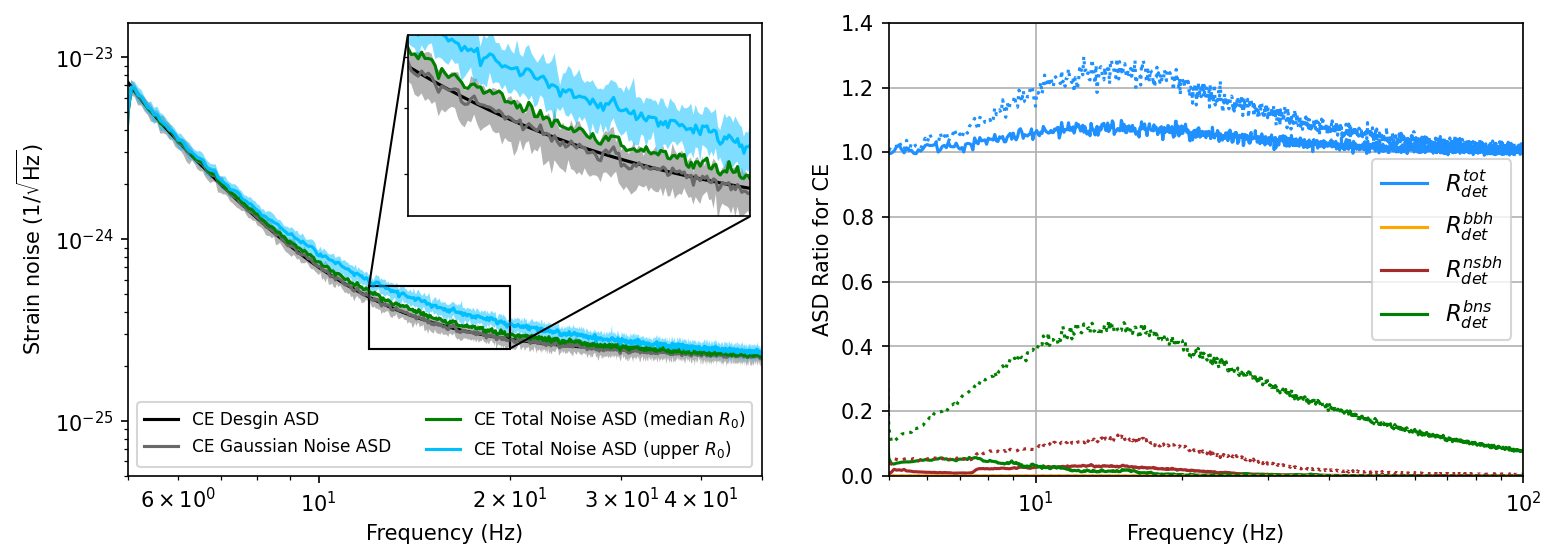

In [21]:
# plot these two together

f = plt.figure(figsize=(12,4), dpi=150)
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.loglog(asd_CE[0], asd_CE[1], color="black", label="CE Desgin ASD")
ax1.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_det), color="dimgray", label="CE Gaussian Noise ASD")
ax1.fill_between(psd_CE_det[0], np.sqrt(onesigma_left_psd_CE_det), np.sqrt(onesigma_right_psd_CE_det), alpha=.5, linewidth=0, color="dimgray")
ax1.loglog(psd_CE_total_median[0], np.sqrt(mean_psd_CE_total_median), color="green", label=r"CE Total Noise ASD (median $R_{0}$)")
ax1.loglog(psd_CE_total_upper[0], np.sqrt(mean_psd_CE_total_upper), color="deepskyblue", label=r"CE Total Noise ASD (upper $R_{0}$)")
ax1.fill_between(psd_CE_total_upper[0], np.sqrt(onesigma_left_psd_CE_total_upper), np.sqrt(onesigma_right_psd_CE_total_upper), alpha=.5, linewidth=0, color="deepskyblue")

ax1.set_xlim(5, 50)
ax1.set_ylim(0.5*10**(-25), )
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"Strain noise (1/$\sqrt{\mathrm{Hz}}$)")
ax1.legend(loc="lower center", fontsize=8.2, ncol=2)

axins = inset_axes(ax1, width="60%", height="40%", loc='lower left',
                   bbox_to_anchor=(0.425, 0.55, 0.9, 1),
                   bbox_transform=ax1.transAxes)

axins.loglog(asd_CE[0], asd_CE[1], color="black")
axins.loglog(psd_CE_det[0], np.sqrt(mean_psd_CE_det), color="dimgray")
axins.fill_between(psd_CE_det[0], np.sqrt(onesigma_left_psd_CE_det), np.sqrt(onesigma_right_psd_CE_det), alpha=.5, linewidth=0, color="dimgray")
axins.loglog(psd_CE_total_median[0], np.sqrt(mean_psd_CE_total_median), color="green")
axins.loglog(psd_CE_total_upper[0], np.sqrt(mean_psd_CE_total_upper), color="deepskyblue")
axins.fill_between(psd_CE_total_upper[0], np.sqrt(onesigma_left_psd_CE_total_upper), np.sqrt(onesigma_right_psd_CE_total_upper), alpha=.5, linewidth=0, color="deepskyblue")

x1, x2, y1, y2 = 12, 20, 2.5*10**(-25), 5.5*10**(-25)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.tick_params(which='both', bottom=False, labelbottom=False, labelleft=False)
mark_inset(ax1, axins, loc1=2, loc2=4, fc="none", ec='k', lw=1)
ax1.indicate_inset_zoom(axins, edgecolor="black")

ax2.semilogx(psd_CE_det[0], ratio_tot_guassian_median, color='dodgerblue', label=r"$R_{det}^{tot}$")
ax2.semilogx(psd_CE_det[0], ratio_bbh_guassian_median, color='orange', label=r"$R_{det}^{bbh}$")
ax2.semilogx(psd_CE_det[0], ratio_nsbh_guassian_median, color='brown', label=r"$R_{det}^{nsbh}$")
ax2.semilogx(psd_CE_det[0], ratio_bns_guassian_median, color='green', label=r"$R_{det}^{bns}$")

ax2.semilogx(psd_CE_det[0], ratio_tot_guassian_upper, color='dodgerblue', linestyle='dotted')
ax2.semilogx(psd_CE_det[0], ratio_bbh_guassian_upper, color='orange', linestyle='dotted')
ax2.semilogx(psd_CE_det[0], ratio_nsbh_guassian_upper, color='brown', linestyle='dotted')
ax2.semilogx(psd_CE_det[0], ratio_bns_guassian_upper, color='green', linestyle='dotted')

ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("ASD Ratio for CE")
ax2.set_xlim(5, 100)
ax2.set_ylim(0, 1.4)
ax2.legend(loc='center right', fontsize=11)
ax2.grid()
f.savefig('asd_bias_and_ratio_CE.pdf', dpi=500)
f.show()